In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits

In [2]:
%matplotlib notebook

In [3]:
# Now we need to fit this. Let's first code the model. 
from scipy.special import wofz
def V(x, alpha, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

def voigt(center,doppler,damp,ll):
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)

In [4]:
def me(S1, S2, eta, vlos, deltav, loga, ll0, ll):
    
    center = ll0 * (1.0 + vlos / 3E5)
    doppler  = deltav/3E5 * ll0
    a = 10.0 ** loga
    profile = voigt(center, doppler, a, ll)
    
    return S1 + S2 / (1.0 + eta * profile)
    
    

In [5]:
def cloud(S, deltatau, vlos, deltav, loga, ll0, ll, I_incoming):
    
    center = ll0 * (1.0 + vlos / 3E5) # line center in Angstroms, shifted due to velocity
    doppler  = deltav/3E5 * ll0 # Doppler width in angstroms
    
    a = 10.0 ** loga
    profile = voigt(center, doppler, a, ll)
    
    tau_lambda = deltatau * profile
    
    return I_incoming * np.exp(-tau_lambda) + S * (1.0 - np.exp(-tau_lambda))
    
    

In [117]:
def model_synth(p, ll0, ll):
    
    
    spectrum_atmos = me(p[0], p[1], p[2], p[3], p[4], p[5], ll0, ll)
    
    spectrum_final = cloud(p[6], p[7], p[8], p[9], p[10] ,ll0, ll, spectrum_atmos)
    
    return spectrum_final

In [7]:
#let's try now scipy.optimize.minimize

def chi2(p, x, y, ll0, error):
    
    #x is ll
    #y are the observed stokes 
    #uncertanties in y
    
    y_model = model(p,ll0, x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

In [8]:
ll = np.linspace(6560.0, 6565.0, 501)
ll0 = 6562.8

vlos = 5.0 # km/s
deltav = 10. # km/s 
loga = -0.2

S1 = 0.3
S2 = 0.7 
eta = 200

spectrum0 = me(S1, S2, eta, vlos, deltav, loga, ll0, ll)

In [10]:
data = fits.open("/home/milic/data/scratch/mihi_data.fits")[0].data

In [11]:
data.shape

(146, 160, 4, 638)

<IPython.core.display.Javascript object>


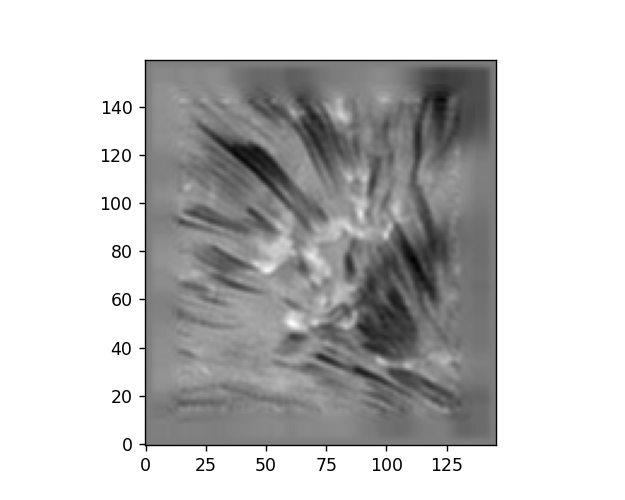

In [12]:
plt.clf()
plt.figure(figsize=[5,4])
plt.imshow(np.sum(data[:,:,0,200:205], axis =2).T, origin='lower', cmap='grey')

<IPython.core.display.Javascript object>


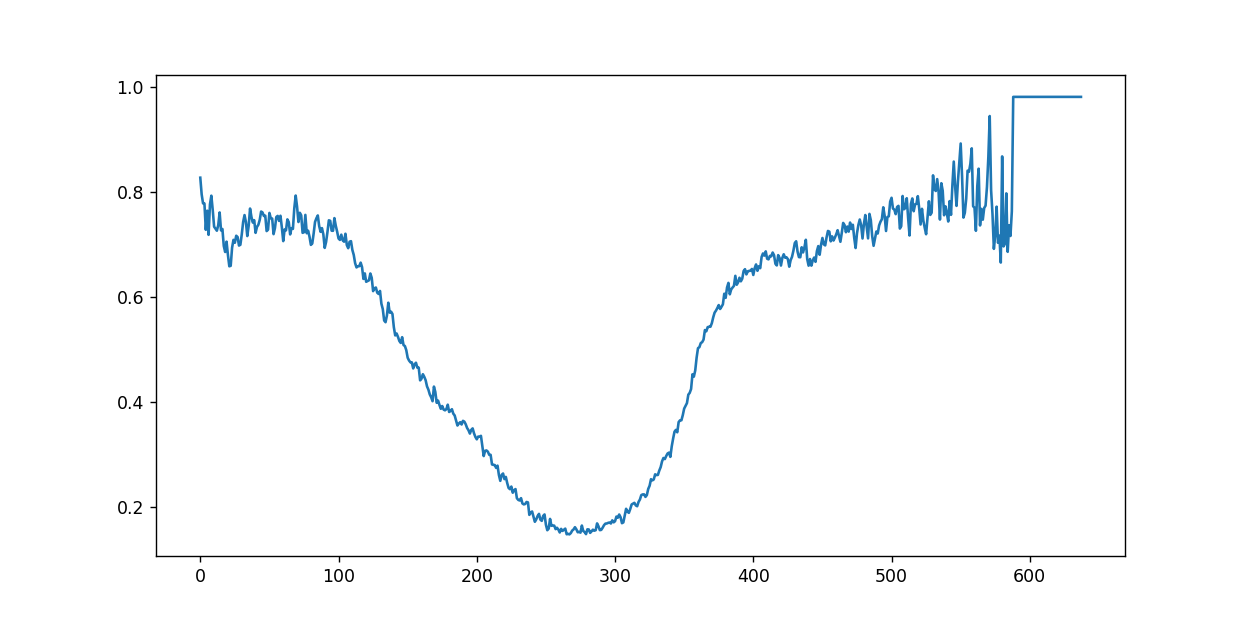

In [13]:
plt.figure(figsize=[10,5])
plt.plot(data[48,119,0,:])

In [51]:
lmin = 45
lmax = 525

In [52]:
ll = fits.open("/home/milic/data/scratch/mihi_data.fits")[1].data[lmin:lmax]


In [41]:
#def me(S1, S2, eta, vlos, deltav, a, ll0, ll):
#def cloud(S, deltatau, vlos, deltav, a, ll0, ll, I_incoming):

params = np.array([0.10, 0.7, 100.0, 0.0, 2.0, -1, 0.1, 10.0, -30.0, 2.0, -4.0])

In [42]:
b=[(0.0,2.0), #S1
        (-2.0,2.0), # S2 
        (80,120.), # eta
        (-5,5), # vlos
        (1.0,20.0), # delta_v
        (-4,1), # log a
        (0, 2.0), # S_cloud
        (0,100), # delta_tau
        (-150, 150), # vlos_cloud
        (1.0, 15.0), # deltav_cloud
        (-4, -1)] # log_a_cloud

In [63]:
# Break the below code in a few steps:
from scipy.optimize import minimize
i = 44
j = 54

spectrum_to_fit = data[i,j,0,lmin:lmax]
result = minimize(chi2,params,args=(ll,spectrum_to_fit,ll0, 1E-4), bounds=b)

print (result.x)

[  0.1952996    0.59481783 120.           2.60933474   9.36059922
  -0.89886688   0.68251758   1.59906381  42.51722641   1.
  -1.1044119 ]


<IPython.core.display.Javascript object>


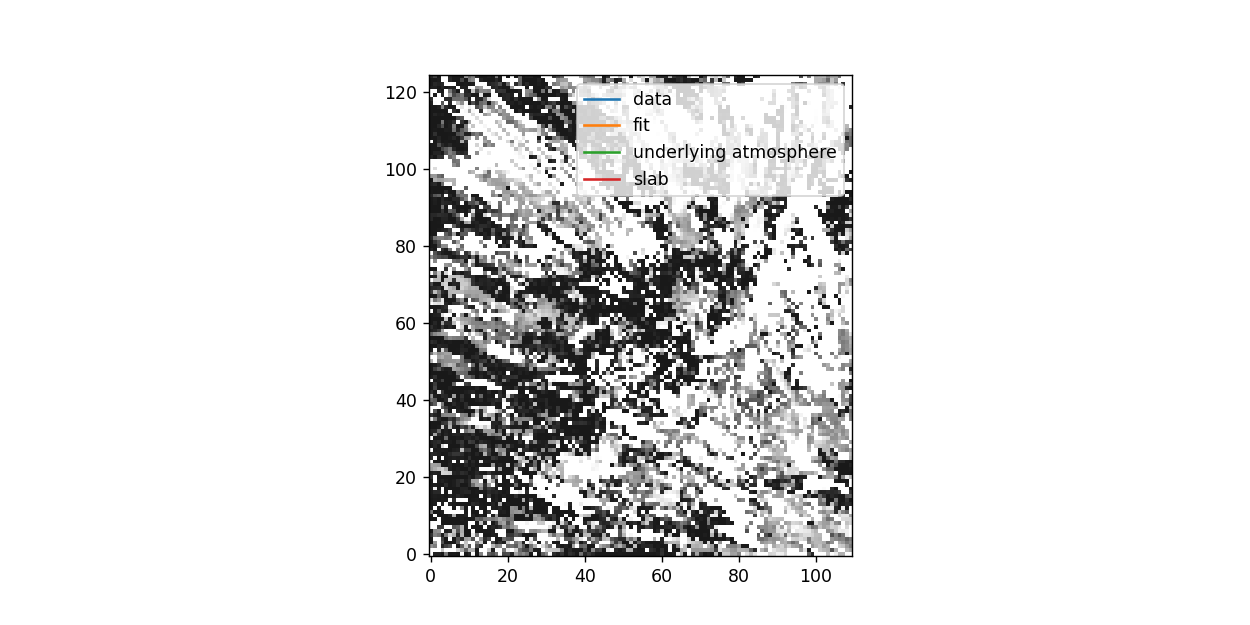

In [64]:
synth = model(result.x, ll0, ll)
atmos_part = me(result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5], ll0, ll)
slab_part = cloud(result.x[6], result.x[7], result.x[8], result.x[9], result.x[10], ll0, ll, result.x[0]+result.x[1])
plt.figure(figsize=[10,5])
plt.plot(ll, synth, label='data')
plt.plot(ll,spectrum_to_fit, label = 'fit')
plt.plot(ll, atmos_part, label = 'underlying atmosphere')
plt.plot(ll, slab_part, label = 'slab')

plt.legend()

In [62]:
print(result.x[2])
print(result.x[3], result.x[4])
print(result.x[8], result.x[9])
print(result.x[6], result.x[7])

114.93174016324959
-1.8005424362423503 12.645232190469704
-5.682073553269397 15.0
0.17353189652822254 5.293878511192962


In [66]:
from tqdm import tqdm

In [68]:
# Let's try the whole cube:
noise = 1E-4
cube = []

for i in tqdm(range(15, 125)):
    for j in range(15,140):
        
        spectrum_to_fit = data[i,j,0,45:525]
        result = minimize(chi2,params,args=(ll,spectrum_to_fit,ll0, noise), bounds=b)
        
        cube.append(result)
        
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [1:21:39<00:00, 44.54s/it]


In [70]:
result = np.asarray(result)

In [72]:
cube.shape

AttributeError: 'list' object has no attribute 'shape'

In [73]:
cube1 = np.asarray(cube)

In [75]:
cube[0].x

array([  0.19961278,   0.61180145, 103.14689151,   2.29278698,
        10.51013488,  -0.82013871,   0.16506663,   8.37283155,
        -2.01561841,  11.6274029 ,  -3.49740564])

In [76]:
len(cube)

13750

In [77]:
model = np.zeros([13750, 11])

In [79]:
for i in range (0,13750):
    model[i,:] = cube[i].x

In [80]:
model.shape

(13750, 11)

In [82]:
model = model.reshape(110,125,11)

In [111]:
%matplotlib qt4
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

<IPython.core.display.Javascript object>


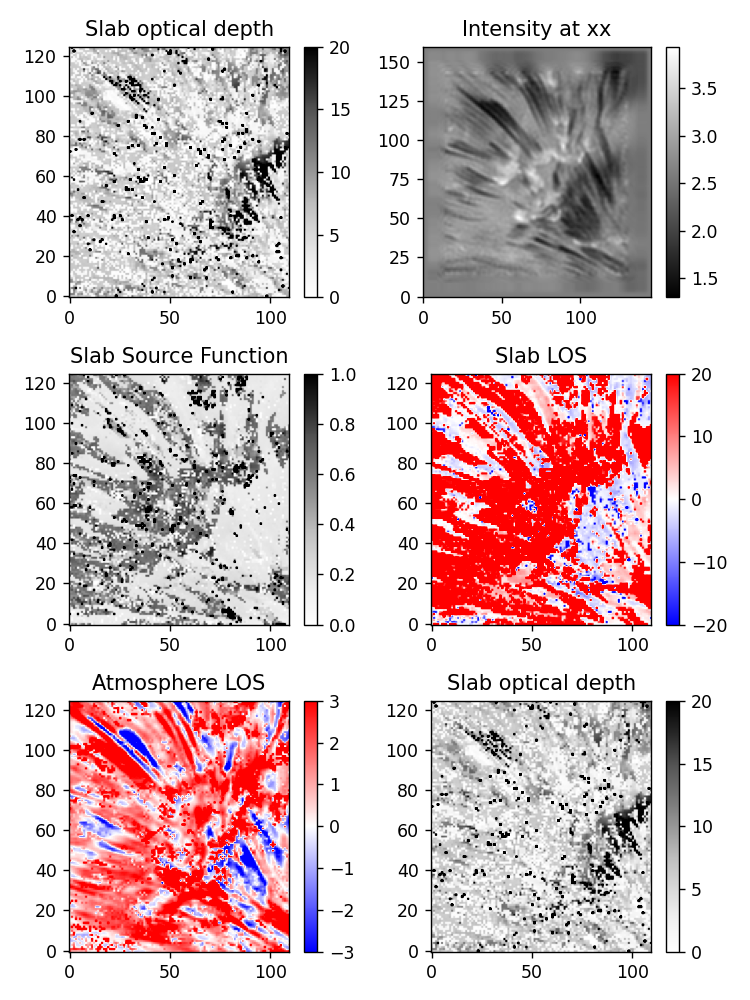

In [123]:
plt.figure(figsize=[6,8])
plt.subplot(321)
plt.title('Slab optical depth')
plt.imshow(model[:,:,7].T, origin='lower', cmap='Grays', vmin=0,vmax=20)
plt.colorbar()
plt.subplot(322)
plt.title('Intensity at xx')
plt.imshow(np.sum(data[:,:,0,200:205], axis =2).T, origin='lower', cmap='grey')
plt.colorbar()
plt.subplot(323)
plt.title('Slab Source Function')
plt.imshow(model[:,:,6].T, origin='lower', cmap='Grays', vmin=0,vmax=1)
plt.colorbar()
plt.subplot(324)
plt.title('Slab LOS')
plt.imshow(model[:,:,8].T, origin='lower', cmap='bwr', vmin=-20,vmax=20)
plt.colorbar()
plt.subplot(325)
plt.title('Atmosphere LOS')
plt.imshow(model[:,:,3].T, origin='lower', cmap='bwr', vmin=-3,vmax=3)
plt.colorbar()
plt.subplot(326)
plt.title('Slab optical depth')
plt.imshow(model[:,:,7].T, origin='lower', cmap='Grays', vmin=0,vmax=20)
plt.colorbar()
plt.tight_layout()
plt.savefig('inversion.png', bbox_inches='tight')


<IPython.core.display.Javascript object>


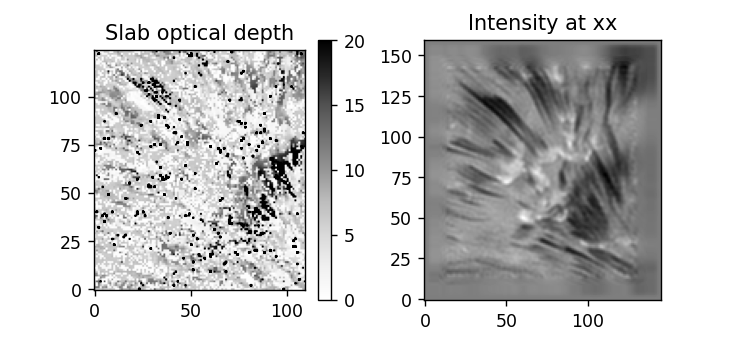

In [124]:
plt.figure(figsize=[6,2.7])
plt.subplot(121)
plt.title('Slab optical depth')
plt.imshow(model[:,:,7].T, origin='lower', cmap='Grays', vmin=0,vmax=20)
plt.colorbar()
plt.subplot(122)
plt.title('Intensity at xx')
plt.imshow(np.sum(data[:,:,0,200:205], axis =2).T, origin='lower', cmap='grey')

<IPython.core.display.Javascript object>


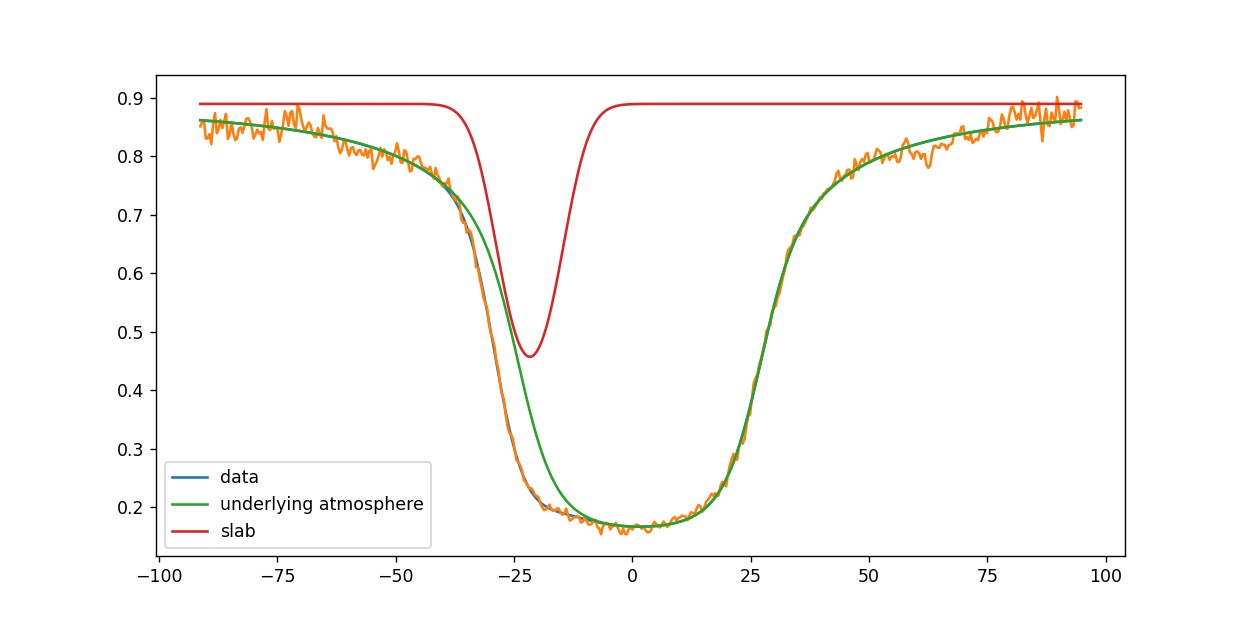

In [129]:
i = 80
j = 66

vsl = (ll-6562.8) / 6562.8 * 3E5

synth = model_synth(model[i,j,:], ll0, ll)
atmos_part = me(model[i,j][0], model[i,j][1], model[i,j][2], model[i,j][3], model[i,j][4], model[i,j][5], ll0, ll)
slab_part = cloud(model[i,j][6], model[i,j][7], model[i,j][8], model[i,j][9], model[i,j][10], ll0, ll, model[i,j][0]+model[i,j][1])
plt.figure(figsize=[10,5])
plt.plot(vsl, synth, label='data')
plt.plot(vsl, data[i+15,j+15,0,lmin:lmax])
plt.plot(vsl, atmos_part, label = 'underlying atmosphere')
plt.plot(vsl, slab_part, label = 'slab')

plt.legend()

In [128]:
model[i,j]

array([  0.15016682,   0.73916675, 101.05556523,   1.48555536,
        10.38481959,  -1.02376109,   0.12989134,   1.79308919,
       -21.65747422,   6.67390558,  -3.64956077])